# Denoising and Detoning

In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
import sys


In [3]:
sys.path.append('../')

In [4]:
import matplotlib.pyplot as plt 

In [5]:
from ml4am.denoising_refactored import *

/Users/oualid/Documents/Documents/Projects/omroot_repos/ML4AM/notebooks/../ml4am/denoising_refactored.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pts: int)-> pd.Series():


## The Marcenko-Pastur Theorem 

In [6]:
x=np.random.normal(size=(10000,1000)) 

In [7]:
matrix = np.corrcoef(x,rowvar=0)

In [8]:
eigenvalues,eigenvectors=getPCA(matrix) 

In [9]:
q=x.shape[0]/float(x.shape[1])

In [10]:
theoretical_pdf =MarcenkoPasturPDF(1.,q=q,pts=1000) 

In [11]:
empirical_pdf=FitEvaluateKernelDensityEstimator(observations = np.diag(eigenvalues),
                                                kernel_bandwidth=.01) # empirical pdf

Text(0.5, 1.0, 'A visualization of the Marcenko-Patur Theorem')

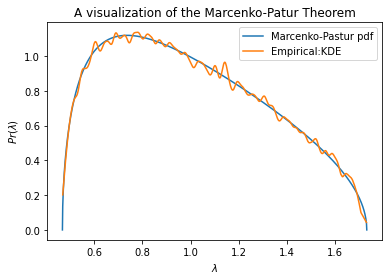

In [12]:
_=plt.plot(theoretical_pdf.index, theoretical_pdf ,'-', label="Marcenko-Pastur pdf")
_=plt.plot(empirical_pdf.index, empirical_pdf ,'-', label="Empirical:KDE")
plt.legend(loc="upper right")
plt.xlabel(r'$\lambda$')    
plt.ylabel(r'$Pr(\lambda)$')  
plt.title('A visualization of the Marcenko-Patur Theorem')

## Random Matrix with Signal

In [13]:
alpha=.95
number_total_factors=1000
number_signal_factors=100
q=10 

In [14]:
random_covariance_matrix =np.cov(np.random.normal(size=(number_total_factors*q,number_total_factors)),rowvar=0) 


In [15]:
random_covariance_matrix.shape

(1000, 1000)

In [16]:
random_covariance_matrix=alpha*random_covariance_matrix+(1-alpha)*generate_random_covariance(number_total_factors,
                                                                                             number_signal_factors) # noise+signal 


In [17]:

random_correlation_matrix=covariance2correlation(random_covariance_matrix)


In [18]:
eigenvalues,eigenvectors=getPCA(random_correlation_matrix)

In [19]:
np.diag(eigenvalues)[0:10]

array([14.22577243, 13.97777648, 13.51944946, 13.23080647, 13.0791493 ,
       13.00297031, 12.90336898, 12.69481168, 12.44277509, 12.31782867])

In [20]:
theoretical_pdf =MarcenkoPasturPDF(1.,q=x.shape[0]/float(x.shape[1]),pts=1000) 


In [21]:
best_kernel_bandwidth = find_optimal_kernel_bandwidth(np.diag(eigenvalues))

In [22]:
best_kernel_bandwidth['bandwidth']

0.17097465139375173

In [23]:
empirical_pdf=FitEvaluateKernelDensityEstimator(np.diag(eigenvalues),
                                       kernel_bandwidth=best_kernel_bandwidth['bandwidth']) # empirical pdf

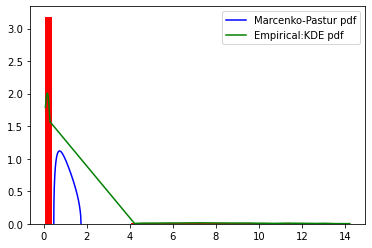

In [24]:
fig = plt.figure()
ax  = fig.add_subplot(111)
_=ax.hist(np.diag(eigenvalues), color='r',density = True, bins=50) # Histogram the eigenvalues
plt.plot(theoretical_pdf.index, theoretical_pdf, color='b', label="Marcenko-Pastur pdf")
plt.plot(empirical_pdf.index, empirical_pdf, color='g', label="Empirical:KDE pdf")

#plt.plot(pdf1.keys(), pdf1, color='g', label="Empirical:KDE")
#plt.plot(x_range, pdf2, color='b', label="Eigenvalues of random-matrix with signal")
plt.legend(loc="upper right")
plt.show()   

## Fitting the Marcenko-Pastur Distribution 

In [25]:
q

10

In [26]:
max_random_eigenvalue,learned_variance = find_max_random_eigenvalue(np.diag(eigenvalues),
                                q,
                                kernel_bandwidth=best_kernel_bandwidth['bandwidth'])

      fun: 663.2453828386441
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1108.02550933])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([0.99999])
found errPDFs 0.99999


In [27]:
max_random_eigenvalue,learned_variance

(1.7324382074783558, 0.9982575791169037)

In [28]:
number_signal_factors =eigenvalues.shape[0]-np.diag(eigenvalues)[::-1].searchsorted(max_random_eigenvalue)

In [29]:
number_signal_factors

100

In [30]:
fitted_theoretical_pdf = MarcenkoPasturPDF(learned_variance,
                                           q ,
                                           pts=1000) 


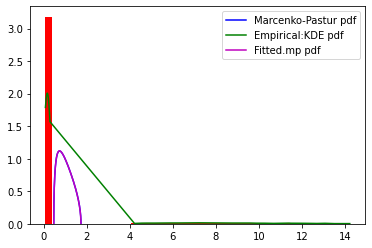

In [31]:
fig = plt.figure()
ax  = fig.add_subplot(111)
_=ax.hist(np.diag(eigenvalues), color='r',density = True, bins=50) # Histogram the eigenvalues
plt.plot(theoretical_pdf.index, theoretical_pdf, color='b', label="Marcenko-Pastur pdf")
plt.plot(empirical_pdf.index, empirical_pdf, color='g', label="Empirical:KDE pdf")
plt.plot(fitted_theoretical_pdf.index, fitted_theoretical_pdf, color='m', label="Fitted.mp pdf")

#plt.plot(pdf1.keys(), pdf1, color='g', label="Empirical:KDE")
#plt.plot(x_range, pdf2, color='b', label="Eigenvalues of random-matrix with signal")
plt.legend(loc="upper right")
plt.show()   

## Hyperparameter Fine tuning of M-P distribution

In [32]:
best_kernel_bandwidth = find_optimal_kernel_bandwidth(np.diag(eigenvalues))

In [33]:
best_kernel_bandwidth

{'bandwidth': 0.17097465139375173}

In [34]:
STOP

NameError: name 'STOP' is not defined

## Denoising 

In [ ]:
denoised_correlation_matrix = denoise_correlation_matrix(eigenvalues ,
                               eigenvectors ,
                               number_signal_factors )

In [ ]:
denoised_eigenvalues , denoised_eigenvectors = getPCA(denoised_correlation_matrix)

In [ ]:
denoised_eigenvalues = np.diag(denoised_eigenvalues)
prior_eigenvalues = np.diag(eigenvalues)
plt.plot(range(0, len(denoised_eigenvalues)), np.log(denoised_eigenvalues), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(prior_eigenvalues)), np.log(prior_eigenvalues), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.show()

In [ ]:
denoised_correlation_matrix_2 = shrinkage_denoise_correlation_matrix(eigenvalues,
                                          eigenvectors,
                                          number_signal_factors,
                                          alpha=0.5)

In [ ]:
corr1 = denoisedCorr2(eVal01, eVec01, nFacts0, alpha=0.5)   
eVal1, eVec1 = getPCA(corr1)

In [ ]:
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal01)
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.show()

## Detoning 

In [ ]:
corr_detoned_denoised = detoned_corr(corr1, eVal1, eVec1)

eVal1_detoned, eVec1_detoned = getPCA(corr_detoned_denoised)
detoned_denoised_eigenvalue = np.diag(eVal1_detoned)
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal01)

In [ ]:


plt.plot(range(0, len(detoned_denoised_eigenvalue)), np.log(detoned_denoised_eigenvalue), color='b', label="Detoned, denoised eigen-function")
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.show()

## Monte Carlo Experiment

In [ ]:
nBlocks, bSize, bCorr = 2, 2, .5
np.random.seed(0)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)

In [ ]:
# code snippet 2.10
nObs, nTrials, bWidth, shrink, minVarPortf = 5, 5, .01, False, True
w1 = pd.DataFrame(columns = range(cov0.shape[0]), index = range(nTrials), dtype=float)

w1_d = w1.copy(deep=True)
np.random.seed(0)

In [ ]:
for i in range(nTrials):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink = shrink)
    if minVarPortf: mu1 = None
    cov1_d = deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = optPort(cov1, mu1).flatten() # add column vector w as row in w1
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten() # np.sum(w1_d, axis=1) is vector of 1's. sum(np.sum(w1_d, axis=0)= nTrials
    # so minimum-variance-portfolio is 1./nTrials*(np.sum(w1_d, axis=0)) - but distribution not stationary


In [ ]:




min_var_port = 1./nTrials*(np.sum(w1_d, axis=0)) 
#code snippet 2.11
w0 = optPort(cov0, None if minVarPortf else mu0) # w0 true percentage asset allocation
w0 = np.repeat(w0.T, w1.shape[0], axis=0) 
rmsd = np.mean((w1-w0).values.flatten()**2)**.5     #RMSE not denoised
rmsd_d = np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE denoised
print("RMSE not denoised:"+str( rmsd))
print("RMSE denoised:"+str( rmsd_d))